# Clustering (unsupervised)

In [1]:
import pandas as pd
df = pd.read_csv("online_shoppers_intention.csv")

df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

## Preparation

In [3]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop("Revenue", axis=1)
y = df["Revenue"]

# Split the dataset
# We use stratify=y to keep the 85/15 buy/no-buy ratio consistent
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Feature Selection

In [4]:
# Exclude contextual and target-related columns
# Only retain behavioral/navigational features for clustering
clustering_cols = [
    'Administrative', 'Administrative_Duration', 
    'Informational', 'Informational_Duration', 
    'ProductRelated', 'ProductRelated_Duration', 
    'BounceRates', 'ExitRates', 'PageValues'
]

# Create the subsets specifically for the clustering algorithm
X_train_clus = X_train[clustering_cols].copy()
X_test_clus = X_test[clustering_cols].copy()

## Preprocessing

In [5]:
from sklearn.preprocessing import StandardScaler

# K-Means needs all features to be on the same scale (mean=0, sigma=1)
scaler = StandardScaler()

# Fit ONLY on the training data to avoid data leakage
X_train_clus_scaled = scaler.fit_transform(X_train_clus)

# Transform the test data using the training scaler
X_test_clus_scaled = scaler.transform(X_test_clus)

## Determine the "K" (Number of Clusters)

We need to decide how many types of customers exist. Our synopsis mentions Huseynov and Yıldırım (2016) found five segments, but we will check if our data might show something else.

- **Elbow Method:** Plot the "inertia" (sum of squared distances) for $k=2$ to $k=10$. Look for the "elbow" where the curve bends.
- **Silhouette Score:** Check how well-separated the clusters are.

Running Elbow Method...
k=2: Inertia=70039.48
k=3: Inertia=54430.81
k=4: Inertia=48049.23
k=5: Inertia=42422.05
k=6: Inertia=37931.17
k=7: Inertia=34800.42
k=8: Inertia=31767.72
k=9: Inertia=29170.40
k=10: Inertia=27067.27


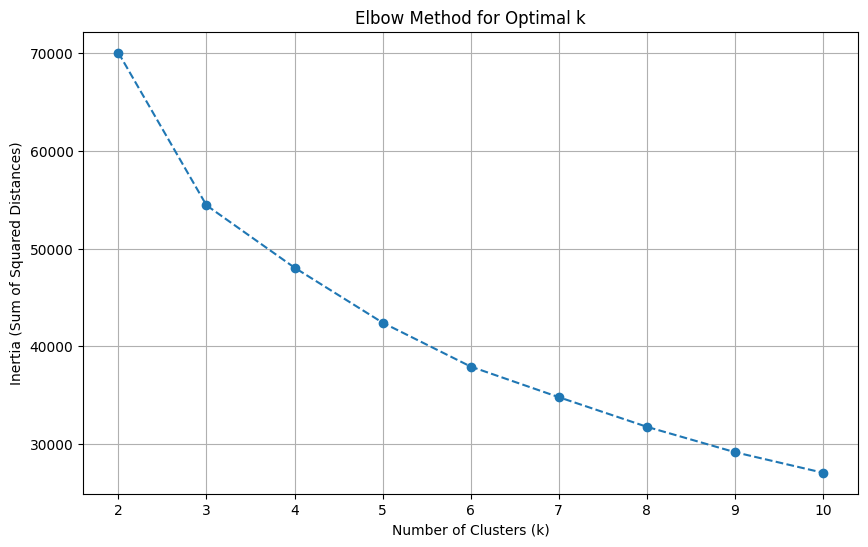

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# We will test cluster counts from 2 to 10
k_values = range(2, 11)
inertia_scores = []

print("Running Elbow Method...")

for k in k_values:
    # 1. Initialize K-Means
    # n_init=10 runs the algorithm 10 times with different random centroids to find the best start
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # 2. Fit ONLY on the scaled training data (Preventing leakage)
    kmeans.fit(X_train_clus_scaled)
    
    # 3. Append the inertia (error) score
    inertia_scores.append(kmeans.inertia_)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}")

# 4. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_scores, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

> Move from 2 to 3: Inertia drops by ~15,600 (Big improvement).

> Move from 3 to 4: Inertia drops by only ~6,400 (Improvement slows down significantly).

> Move from 4 to 5: Inertia drops by ~5,600 (Steady, small decline).

In [7]:
from sklearn.metrics import silhouette_score

print("Running Silhouette Analysis...")

# We test k=2 to k=6 (since the elbow already flattened out after that)
for k in range(2, 7):
    # 1. Initialize and Fit
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_clus_scaled)
    
    # 2. Assign labels
    cluster_labels = kmeans.labels_
    
    # 3. Calculate Silhouette Score
    # Note: This can take a moment if the dataset is large
    score = silhouette_score(X_train_clus_scaled, cluster_labels)
    
    print(f"k={k}: Silhouette Score = {score:.4f}")

Running Silhouette Analysis...
k=2: Silhouette Score = 0.4691
k=3: Silhouette Score = 0.4908
k=4: Silhouette Score = 0.4067
k=5: Silhouette Score = 0.4248
k=6: Silhouette Score = 0.4131


> Again does k=3 have the best score so we will go with 3 clusters instead of the 5 that Huseynov and Yıldırım (2016) found.

## Cluster Analysis

In [8]:
# 1. Fit the Final Model with k=3
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_final.fit(X_train_clus_scaled)

# 2. Assign Labels
# For Training data: Use the labels generated during fitting
X_train_with_cluster = X_train.copy()
X_train_with_cluster['Cluster'] = kmeans_final.labels_

# For Test data: PREDICT using the trained centroids (No peeking!)
X_test_with_cluster = X_test.copy()
X_test_with_cluster['Cluster'] = kmeans_final.predict(X_test_clus_scaled)

# 3. INTERPRET THE CLUSTERS (Crucial for your report)
# We group by the new 'Cluster' column to see the average behavior of each group
# We use the ORIGINAL (unscaled) X_train to make the numbers readable (seconds, counts, etc.)
cluster_analysis = X_train_with_cluster.groupby('Cluster')[clustering_cols].mean()

print("Cluster Center Analysis (Mean Values):")
print(cluster_analysis)

# Check how many people are in each cluster
print("\nCluster Sizes:")
print(X_train_with_cluster['Cluster'].value_counts())

Cluster Center Analysis (Mean Values):
         Administrative  Administrative_Duration  Informational  \
Cluster                                                           
0              7.382979               311.678272       2.495441   
1              1.701103                50.682821       0.218040   
2              0.045077                 0.809095       0.016607   

         Informational_Duration  ProductRelated  ProductRelated_Duration  \
Cluster                                                                    
0                    211.639465       94.349544              3753.279042   
1                      8.127671       23.834263               871.664768   
2                      0.067616        2.897983                57.648375   

         BounceRates  ExitRates  PageValues  
Cluster                                      
0           0.006133   0.019308   10.081004  
1           0.009286   0.032311    5.888456  
2           0.167603   0.181349    0.000000  

Cluster Sizes

> Cluster 1 (7,705 users - ~78%): These are "Standard Browsers." They browse a moderate amount (avg 23 products), stay for a while (14 mins), and have low bounce rates.

> Cluster 0 (1,316 users - ~13%): These are "Power Users / Researchers." They view nearly 4x as many products (94 vs 23) and spend nearly 1 hour on the site (3753s). The fact that this group is smaller makes sense as highly engaged users are rare.

> Cluster 2 (843 users - ~9%): These are "Bouncers / Disinterested." They spend almost no time (57s), view almost nothing, and have very high Bounce/Exit rates (16-18%). PageValues is 0.

## Compare with DBSCAN

In [9]:
from sklearn.cluster import DBSCAN

# Run DBSCAN
# We try eps=1.0 first. If you get only 1 cluster or all noise (-1), adjust eps up or down.
# - Seems that eps=0.5 is the highest that gives multiple clusters
# min_samples=20 means a group needs 20 samples to be a "cluster"
dbscan = DBSCAN(eps=0.5, min_samples=20)
db_labels = dbscan.fit_predict(X_train_clus_scaled)

# Get K-Means Labels
kmeans_labels = kmeans_final.labels_

def print_clustering_stats(name, labels, data):
    unique_labels = set(labels)
    # Remove noise (-1) for silhouette score if using DBSCAN
    if -1 in labels:
        n_clusters = len(unique_labels) - 1
        noise_percent = list(labels).count(-1) / len(labels) * 100
    else:
        n_clusters = len(unique_labels)
        noise_percent = 0
        
    print(f"--- {name} ---")
    print(f"Clusters found: {n_clusters}")
    print(f"Noise (Outliers): {noise_percent:.2f}%")
    
    # Silhouette requires at least 2 clusters (and not just noise)
    if n_clusters > 1:
        score = silhouette_score(data, labels)
        print(f"Silhouette Score: {score:.4f} (Higher is better)")
    else:
        print("Silhouette Score: N/A (Too few clusters)")
    print("-" * 20)

# Compare
print_clustering_stats("K-Means (k=3)", kmeans_labels, X_train_clus_scaled)
print_clustering_stats("DBSCAN (eps=0.5)", db_labels, X_train_clus_scaled)

--- K-Means (k=3) ---
Clusters found: 3
Noise (Outliers): 0.00%
Silhouette Score: 0.4908 (Higher is better)
--------------------
--- DBSCAN (eps=0.5) ---
Clusters found: 4
Noise (Outliers): 33.86%
Silhouette Score: -0.0500 (Higher is better)
--------------------


> DBSCAN with an eps higher than 0.5 fails to create more than one cluster which means that K-means is actually a better fit for our project. DBSCAN assumes constant density but we have dense blobs for most users and then low density areas (more spread out) for the other clusters. DBSCAN finds the blob with eps=0.5 but not the clouds - just marks them as noise - whereas with a higher eps, all gets swallowed into a single cluster.

> While silhouette score generally works better for K-Means, we can still use it when combined with noise. As the silhouette score is very low and noise is very high, it shows that DBSCAN isn't a good fit for our data.

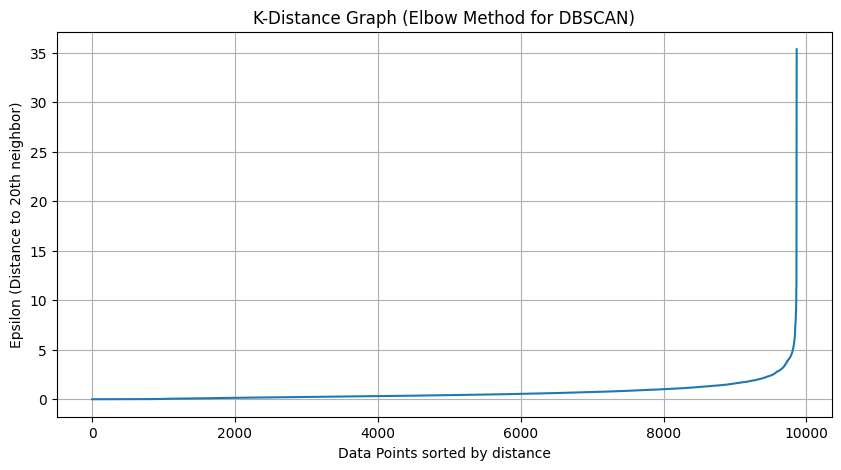

In [10]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Calculate the distance to the nearest n neighbors
# n_neighbors should be equal to your min_samples (20)
nearest_neighbors = NearestNeighbors(n_neighbors=20)
neighbors = nearest_neighbors.fit(X_train_clus_scaled)
distances, indices = neighbors.kneighbors(X_train_clus_scaled)

# Sort distance values by ascending value and plot
distances = np.sort(distances[:, 19], axis=0)
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title("K-Distance Graph (Elbow Method for DBSCAN)")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("Epsilon (Distance to 20th neighbor)")
plt.grid(True)
plt.show()

> As is also shown here, an eps=4.0 is way too high when even 1.0 already creates just one cluster. Therefore DBSCAN is not the right choice here.

## Prediction with K-Means clustering

In [11]:
# Create copies of the original split data so they don't get messed up
X_train_enhanced = X_train.copy()
X_test_enhanced = X_test.copy()

# Add the Cluster labels
X_train_enhanced['Cluster'] = kmeans_final.labels_
X_test_enhanced['Cluster'] = kmeans_final.predict(X_test_clus_scaled)

# Check the new dataframe to make sure Cluster was added correctly
print("Enhanced Training Data:")
print(X_train_enhanced[['Administrative', 'Cluster']].head())

Enhanced Training Data:
      Administrative  Cluster
4263               8        0
5905               0        1
9434               0        1
3505               2        1
2067               0        1


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss, roc_curve
import numpy as np

# We must add "Cluster" to the categorical list
categorical_features_enhanced = [
    "Month", "VisitorType", "Weekend",
    "Browser", "Region", "TrafficType", 
    "OperatingSystems", "Cluster"
]

numeric_features_enhanced = [c for c in X_train_enhanced.columns if c not in categorical_features_enhanced]

preprocessor_enhanced = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_enhanced),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_enhanced),
    ]
)

# We use the same parameters as the tuned pipeline to ensure a fair comparison
tuned_tuned_rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_enhanced),
    ("model", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=5,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=1
    ))
])

def evaluate (model, X_train, y_train, X_test, y_test, name="model"):
    # Ensure y is a plain 1D int array (0/1)
    y_train_int = np.array(y_train).astype(int).ravel()
    y_test_int = np.array(y_test).astype(int).ravel() 
    
    # Fit the model
    model.fit(X_train, y_train_int)

    # Get predicted probabilities
    y_proba_train = model.predict_proba(X_train)[:, 1]
    y_proba_test = model.predict_proba(X_test)[:, 1]

    # Calculate Youden's Index (Optimal Threshold) on TRAIN data
    # We use TRAIN data to avoid data leakage
    fpr, tpr, thresholds = roc_curve(y_train_int, y_proba_train)
    youden_index = tpr - fpr
    # Get the threshold that maximizes Youden's Index
    best_threshold = thresholds[np.argmax(youden_index)]
    
    # Apply the optimal threshold to TEST data
    y_pred_optimized = (y_proba_test >= best_threshold).astype(int)

    print(f"\n=== {name} ===")
    print(classification_report(y_test_int, y_pred_optimized))
    print(f"Optimal Threshold: {best_threshold:.4f}")
    # ROC-AUC measures how well the model understands the difference between a Buyer and a Non-Buyer
    print("ROC-AUC:", roc_auc_score(y_test_int,y_proba_test))
    print("Log-loss:", log_loss(y_test_int, y_proba_test))

# Compare all models again
evaluate(tuned_rf_pipeline, X_train_enhanced, y_train, X_test_enhanced, y_test, "Tuned Random Forest With Clusters")


=== Tuned Random Forest With Clusters ===
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      2084
           1       0.53      0.82      0.64       382

    accuracy                           0.86      2466
   macro avg       0.74      0.84      0.78      2466
weighted avg       0.90      0.86      0.87      2466

Optimal Threshold: 0.4016
ROC-AUC: 0.9191521540332224
Log-loss: 0.3020886686784614


## Feature importance analysis of Tuned Random Forest With Clusters

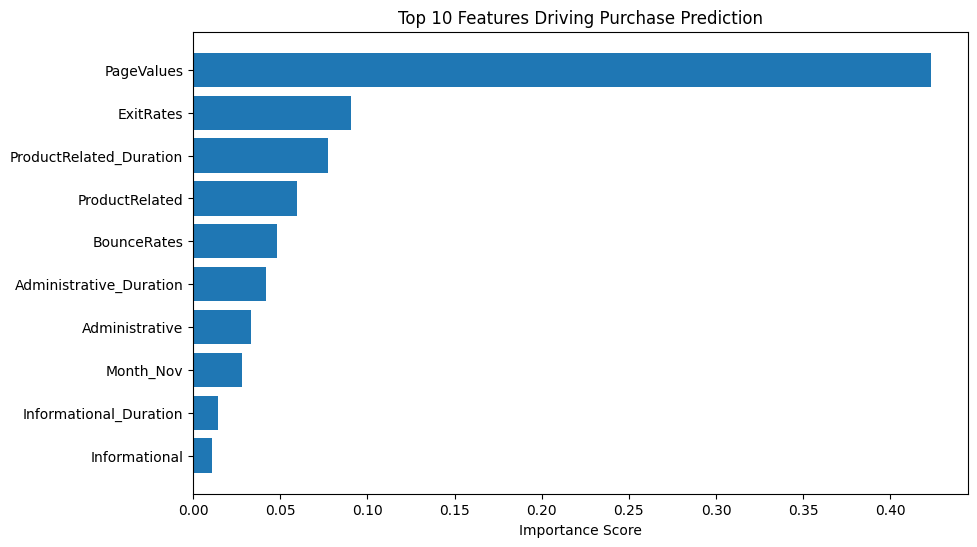

      Feature  Importance
77  Cluster_2    0.008079
75  Cluster_0    0.005945
76  Cluster_1    0.004503
Total features: 78


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the model from the pipeline
rf_model = tuned_rf_pipeline.named_steps['model']
preprocessor = tuned_rf_pipeline.named_steps['preprocessor']

# Get feature names from the one-hot encoder
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features_enhanced)
all_feature_names = numeric_features_enhanced + list(cat_feature_names)

# Create a dataframe of importances
importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10,6))
plt.barh(importances['Feature'][:10], importances['Importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Features Driving Purchase Prediction")
plt.xlabel("Importance Score")
plt.show()

# Check specifically where 'Cluster' ranks
print(importances[importances['Feature'].str.contains("Cluster")])
print('Total features:', len(all_feature_names))

> Clustering does not seem to have much importance as they rank 75-77 out of 78.